In [34]:
# ============================================================================
# TOPIC MODELING ANALYSIS - POLITICAL SPEECHES
# Full corpus analysis (28 speeches)
# ============================================================================

# ============================================================================
# SECTION 1: SETUP & IMPORTS
# ============================================================================

import os
import re
import pandas as pd
import numpy as np
from pprint import pprint

# NLP libraries
import gensim
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel
import spacy
from nltk.corpus import stopwords

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style('whitegrid')
%matplotlib inline

print("All packages imported successfully!")

All packages imported successfully!


In [35]:
# ============================================================================
# SECTION 2: LOAD DATA & METADATA
# ============================================================================

# Load metadata
metadata_path = '/home/albere/compling/data/docs/metadata.csv'  # adjust path
metadata_df = pd.read_csv(metadata_path)

print(f"Metadata loaded: {len(metadata_df)} speeches")
print("\nColumns:", metadata_df.columns.tolist())
print("\nFirst few rows:")
print(metadata_df.head())

Metadata loaded: 28 speeches

Columns: ['text_id', 'country', 'category', 'speaker', 'date', 'title', 'source', 'word_count', 'speech_type', 'downloaded', 'preprocessed', 'filename', 'processed_filename', 'context']

First few rows:
      text_id country    category         speaker        date  \
0  USA_MST_01      US  Mainstream  George W. Bush  02/09/2004   
1  USA_MST_02      US  Mainstream     Mitt Romney  30/08/2012   
2  USA_MST_03      US  Mainstream  George W. Bush  03/08/2000   
3  USA_MST_04      US  Mainstream     Mitt Romney  08/10/2012   
4  USA_MST_05      US  Mainstream     John McCain  04/09/2008   

                   title                                             source  \
0      Acceptance speech  https://www.americanrhetoric.com/speeches/PDFF...   
1      Acceptance speech  https://www.presidency.ucsb.edu/documents/addr...   
2      Acceptance speech  https://www.presidency.ucsb.edu/documents/addr...   
3  Foreign policy speech  https://www.presidency.ucsb.edu/do

In [36]:
# Load speech texts and merge with metadata
speech_dir = '/home/albere/compling/data/processed/'

speeches = []
missing_files = []

for filename in metadata_df['processed_filename']:  # adjust column name if needed
    filepath = os.path.join(speech_dir, filename)
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            speeches.append(f.read())
    except FileNotFoundError:
        print(f"Warning: Could not find {filename}")
        speeches.append("")
        missing_files.append(filename)

metadata_df['text'] = speeches

# Remove any speeches that couldn't be loaded
if missing_files:
    print(f"\nMissing {len(missing_files)} files - removing from dataset")
    metadata_df = metadata_df[metadata_df['text'] != ""]

print(f"\nFinal dataset: {len(metadata_df)} speeches")
print("\nCategory distribution:")
print(metadata_df['category'].value_counts())


Final dataset: 28 speeches

Category distribution:
category
Mainstream    14
Populist      14
Name: count, dtype: int64


In [37]:
# ============================================================================
# SECTION 3: TEXT PREPROCESSING
# ============================================================================

# Load spaCy model
print("Loading spaCy model...")
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
print("Model loaded!")

# Speeches are already cleaned, so skip cleaning step
print("Using pre-cleaned speeches...")
speeches_clean = metadata_df['text'].tolist()

Loading spaCy model...
Model loaded!
Using pre-cleaned speeches...


In [38]:
# Tokenization
def sent_to_words(sentences):
    """Tokenize sentences into words"""
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

print("Tokenizing...")
data_words = list(sent_to_words(speeches_clean))
print(f"Tokenized {len(data_words)} speeches")
print(f"Example - first 20 tokens of speech 1: {data_words[0][:20]}")

Tokenizing...
Tokenized 28 speeches
Example - first 20 tokens of speech 1: ['mr', 'chairman', 'mr', 'chairman', 'delegates', 'fellow', 'citizens', 'honored', 'by', 'your', 'support', 'and', 'accept', 'your', 'nomination', 'for', 'president', 'of', 'the', 'united']


In [39]:
# Remove stopwords
print("\nRemoving stopwords...")
stop_words = stopwords.words('english')
# Add political stopwords that don't add meaning
stop_words.extend(['said', 'going', 'would', 'could', 'also', 'must', 
                   'year', 'years', 'people', 'make', 'want', 'know',
                   'think', 'today', 'time', 'get', 'got'])

def remove_stopwords(texts):
    return [[word for word in doc if word not in stop_words] for doc in texts]

data_words_nostops = remove_stopwords(data_words)
print("Stopwords removed!")
print(f"Example - first 20 tokens after stopword removal: {data_words_nostops[0][:20]}")


Removing stopwords...
Stopwords removed!
Example - first 20 tokens after stopword removal: ['mr', 'chairman', 'mr', 'chairman', 'delegates', 'fellow', 'citizens', 'honored', 'support', 'accept', 'nomination', 'president', 'united', 'states', 'words', 'four', 'ago', 'none', 'us', 'envisioned']


In [40]:
# Lemmatization
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Lemmatize texts, keeping only specified POS tags"""
    texts_out = []
    for i, sent in enumerate(texts):
        if (i+1) % 5 == 0:
            print(f"Processing speech {i+1}/{len(texts)}...")
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

print("\nLemmatizing... (this may take a few minutes)")
data_lemmatized = lemmatization(data_words_nostops)
print("Lemmatization complete!")
print(f"Example - first 20 lemmatized tokens: {data_lemmatized[0][:20]}")


Lemmatizing... (this may take a few minutes)
Processing speech 5/28...
Processing speech 10/28...
Processing speech 15/28...
Processing speech 20/28...
Processing speech 25/28...
Lemmatization complete!
Example - first 20 lemmatized tokens: ['fellow', 'citizen', 'honor', 'support', 'accept', 'nomination', 'word', 'ago', 'none', 'envision', 'bring', 'heart', 'great', 'city', 'see', 'quiet', 'morning', 'see', 'bravery', 'rescuer']


In [41]:
# ============================================================================
# SECTION 4: CREATE DICTIONARY & CORPUS
# ============================================================================

# Create Dictionary
print("Creating dictionary...")
id2word = corpora.Dictionary(data_lemmatized)

print(f"Dictionary created with {len(id2word)} unique tokens")
print(f"\nSample dictionary entries:")
for i in range(10):
    print(f"  ID {i}: {id2word[i]}")

# Create Corpus (Term Document Frequency)
print("\nCreating corpus...")
corpus = [id2word.doc2bow(text) for text in data_lemmatized]
print(f"Corpus created: {len(corpus)} documents")
print(f"\nFirst document (bag-of-words, first 10 terms):")
print(corpus[0][:10])

Creating dictionary...
Dictionary created with 5410 unique tokens

Sample dictionary entries:
  ID 0: able
  ID 1: abroad
  ID 2: accept
  ID 3: access
  ID 4: accessible
  ID 5: account
  ID 6: accountability
  ID 7: achieve
  ID 8: act
  ID 9: action

Creating corpus...
Corpus created: 28 documents

First document (bag-of-words, first 10 terms):
[(0, 2), (1, 2), (2, 1), (3, 1), (4, 1), (5, 5), (6, 1), (7, 1), (8, 5), (9, 1)]


In [42]:
# ============================================================================
# SECTION 5: EXPERIMENT WITH DIFFERENT NUMBERS OF TOPICS
# ============================================================================

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute coherence scores for different numbers of topics
    
    Returns:
    - model_list: List of LDA models
    - coherence_values: Coherence scores for each model
    """
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        print(f"\nTraining model with {num_topics} topics...")
        
        model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha='auto',
            eta='auto',
            per_word_topics=True
        )
        
        model_list.append(model)
        
        coherencemodel = CoherenceModel(
            model=model, 
            texts=texts, 
            dictionary=dictionary, 
            coherence='c_v'
        )
        coherence = coherencemodel.get_coherence()
        coherence_values.append(coherence)
        
        print(f"  Coherence score: {coherence:.4f}")
        
    return model_list, coherence_values

In [43]:
# Test different numbers of topics
# For 28 speeches, test 5, 7, and 10 topics
print("="*60)
print("TESTING DIFFERENT NUMBERS OF TOPICS")
print("="*60)

model_list, coherence_values = compute_coherence_values(
    dictionary=id2word,
    corpus=corpus, 
    texts=data_lemmatized,
    start=5,
    limit=11,
    step=2  # Test 5, 7, 9 topics
)

print("\n" + "="*60)
print("COHERENCE SCORES SUMMARY")
print("="*60)
topic_nums = list(range(5, 11, 2))
for num, score in zip(topic_nums, coherence_values):
    print(f"{num} topics: {score:.4f}")

TESTING DIFFERENT NUMBERS OF TOPICS

Training model with 5 topics...
  Coherence score: 0.2874

Training model with 7 topics...
  Coherence score: 0.3426

Training model with 9 topics...
  Coherence score: 0.3408

COHERENCE SCORES SUMMARY
5 topics: 0.2874
7 topics: 0.3426
9 topics: 0.3408


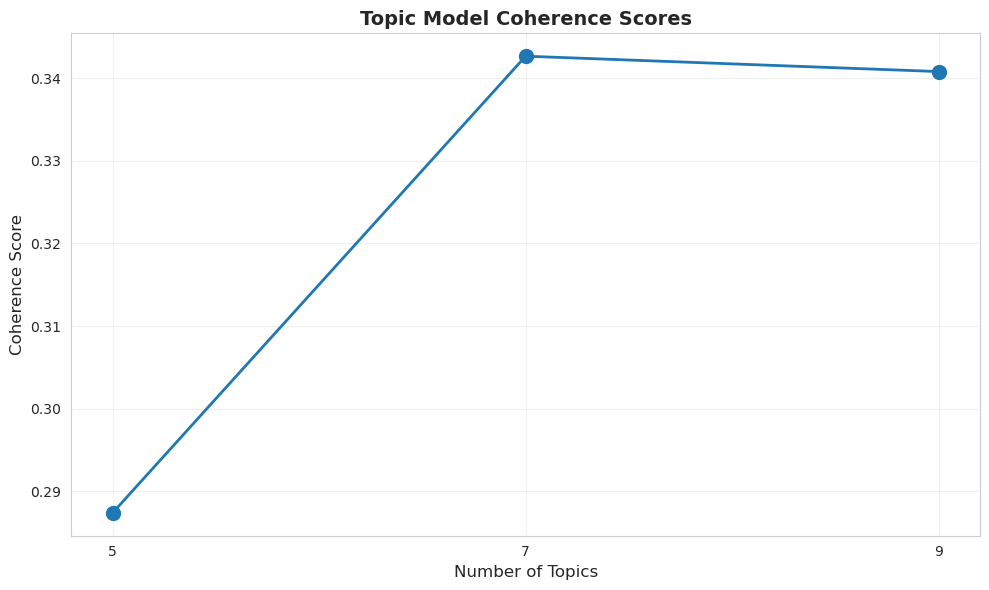


Highest coherence: 7 topics (score: 0.3426)


In [44]:
# Visualize coherence scores
plt.figure(figsize=(10, 6))
plt.plot(topic_nums, coherence_values, marker='o', linewidth=2, markersize=10)
plt.xlabel("Number of Topics", fontsize=12)
plt.ylabel("Coherence Score", fontsize=12)
plt.title("Topic Model Coherence Scores", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(topic_nums)
plt.tight_layout()
plt.show()

# Identify best model by coherence
best_idx = coherence_values.index(max(coherence_values))
best_num_topics = topic_nums[best_idx]
print(f"\nHighest coherence: {best_num_topics} topics (score: {coherence_values[best_idx]:.4f})")

In [45]:
# ============================================================================
# SECTION 6: EXAMINE TOPICS (QUALITATIVE ASSESSMENT)
# ============================================================================

print("="*60)
print("EXAMINING TOPICS FOR EACH MODEL")
print("="*60)

for i, (model, num_topics) in enumerate(zip(model_list, topic_nums)):
    print(f"\n{'='*60}")
    print(f"MODEL WITH {num_topics} TOPICS")
    print(f"{'='*60}\n")
    
    for idx, topic in model.print_topics(-1):
        print(f"Topic {idx}:")
        print(f"  {topic}\n")

EXAMINING TOPICS FOR EACH MODEL

MODEL WITH 5 TOPICS

Topic 0:
  0.012*"country" + 0.009*"great" + 0.009*"right" + 0.008*"take" + 0.008*"go" + 0.007*"come" + 0.007*"work" + 0.006*"job" + 0.006*"thing" + 0.006*"see"

Topic 1:
  0.012*"world" + 0.010*"country" + 0.006*"power" + 0.006*"take" + 0.006*"nation" + 0.006*"leave" + 0.005*"help" + 0.004*"well" + 0.004*"new" + 0.004*"great"

Topic 2:
  0.011*"job" + 0.009*"country" + 0.008*"work" + 0.008*"child" + 0.007*"well" + 0.007*"world" + 0.006*"come" + 0.006*"let" + 0.005*"fight" + 0.005*"great"

Topic 3:
  0.015*"country" + 0.010*"say" + 0.009*"party" + 0.008*"need" + 0.007*"come" + 0.007*"great" + 0.007*"good" + 0.006*"well" + 0.006*"take" + 0.006*"thing"

Topic 4:
  0.014*"great" + 0.010*"country" + 0.009*"thank" + 0.007*"go" + 0.007*"come" + 0.007*"see" + 0.006*"say" + 0.005*"good" + 0.005*"right" + 0.005*"job"


MODEL WITH 7 TOPICS

Topic 0:
  0.013*"country" + 0.011*"work" + 0.008*"government" + 0.007*"new" + 0.007*"take" + 0.006*"me

In [56]:
# ============================================================================
# SECTION 7: SELECT OPTIMAL MODEL & NAME TOPICS
# ============================================================================

# Choose the model you want to use
# You can choose based on coherence OR interpretability
# Let's say we choose 7 topics (index 1) - adjust as needed

optimal_model_idx = 1  # Adjust this based on your assessment
optimal_model = model_list[optimal_model_idx]
optimal_num_topics = topic_nums[optimal_model_idx]

print(f"Selected model: {optimal_num_topics} topics")
print(f"Coherence score: {coherence_values[optimal_model_idx]:.4f}")

# Manually name topics based on examination
# YOU NEED TO FILL THIS IN after looking at the topics above
topic_names = {
    0: "Domestic Governance (General)",    
    1: "Foreign Policy & Security",
    2: "Economy & Employment",
    3: "Electoral & Party Politics",
    4: "National Identity & Values",
    5: "Sovereignty & Decision-Making",
    6: "Speech Performance (Artifacts)",
    # Add more as needed based on optimal_num_topics
}

print("\nTopic names:")
for idx, name in topic_names.items():
    print(f"  Topic {idx}: {name}")

Selected model: 7 topics
Coherence score: 0.3426

Topic names:
  Topic 0: Domestic Governance (General)
  Topic 1: Foreign Policy & Security
  Topic 2: Economy & Employment
  Topic 3: Electoral & Party Politics
  Topic 4: National Identity & Values
  Topic 5: Sovereignty & Decision-Making
  Topic 6: Speech Performance (Artifacts)


In [57]:
# ============================================================================
# SECTION 8: ANALYZE TOPIC DISTRIBUTIONS BY CATEGORY
# ============================================================================

# Get topic distribution for each speech
print("Computing topic distributions for all speeches...")

topic_distributions = []

for i, speech_bow in enumerate(corpus):
    topic_dist = optimal_model.get_document_topics(speech_bow)
    
    # Convert to full distribution (include zero probabilities)
    full_dist = [0.0] * optimal_model.num_topics
    for topic_id, prob in topic_dist:
        full_dist[topic_id] = prob
    
    topic_distributions.append(full_dist)

# Add topic distributions to dataframe
for topic_num in range(optimal_model.num_topics):
    metadata_df[f'topic_{topic_num}'] = [dist[topic_num] for dist in topic_distributions]

print("Topic distributions computed!")
print("\nDataFrame now includes topic columns:")
print(metadata_df.columns.tolist())

Computing topic distributions for all speeches...
Topic distributions computed!

DataFrame now includes topic columns:
['text_id', 'country', 'category', 'speaker', 'date', 'title', 'source', 'word_count', 'speech_type', 'downloaded', 'preprocessed', 'filename', 'processed_filename', 'context', 'text', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'type']


In [58]:
# Calculate average topic distribution by category
print("\n" + "="*60)
print("AVERAGE TOPIC DISTRIBUTION BY CATEGORY")
print("="*60)

categories = metadata_df['category'].unique()

for category in sorted(categories):
    print(f"\n{category.upper()}:")
    category_df = metadata_df[metadata_df['category'] == category]
    print(f"  (n = {len(category_df)} speeches)")
    
    for topic_num in range(optimal_model.num_topics):
        avg = category_df[f'topic_{topic_num}'].mean()
        topic_name = topic_names.get(topic_num, f"Topic {topic_num}")
        print(f"  {topic_name}: {avg:.2%}")


AVERAGE TOPIC DISTRIBUTION BY CATEGORY

MAINSTREAM:
  (n = 14 speeches)
  Domestic Governance (General): 25.98%
  Foreign Policy & Security: 9.51%
  Economy & Employment: 26.26%
  Electoral & Party Politics: 12.00%
  National Identity & Values: 15.32%
  Sovereignty & Decision-Making: 7.14%
  Speech Performance (Artifacts): 3.56%

POPULIST:
  (n = 14 speeches)
  Domestic Governance (General): 4.12%
  Foreign Policy & Security: 0.00%
  Economy & Employment: 2.27%
  Electoral & Party Politics: 47.58%
  National Identity & Values: 0.00%
  Sovereignty & Decision-Making: 7.14%
  Speech Performance (Artifacts): 38.87%


In [59]:
# Create comparison dataframe
comparison_data = []

for category in sorted(categories):
    category_df = metadata_df[metadata_df['category'] == category]
    for topic_num in range(optimal_model.num_topics):
        avg = category_df[f'topic_{topic_num}'].mean()
        comparison_data.append({
            'Category': category,
            'Topic': topic_names.get(topic_num, f"Topic {topic_num}"),
            'Topic_Num': topic_num,
            'Average_Proportion': avg
        })

comparison_df = pd.DataFrame(comparison_data)
print("\nComparison dataframe created")
print(comparison_df.head(10))


Comparison dataframe created
     Category                           Topic  Topic_Num  Average_Proportion
0  Mainstream   Domestic Governance (General)          0            0.259784
1  Mainstream       Foreign Policy & Security          1            0.095128
2  Mainstream            Economy & Employment          2            0.262595
3  Mainstream      Electoral & Party Politics          3            0.120030
4  Mainstream      National Identity & Values          4            0.153227
5  Mainstream   Sovereignty & Decision-Making          5            0.071422
6  Mainstream  Speech Performance (Artifacts)          6            0.035643
7    Populist   Domestic Governance (General)          0            0.041222
8    Populist       Foreign Policy & Security          1            0.000000
9    Populist            Economy & Employment          2            0.022704


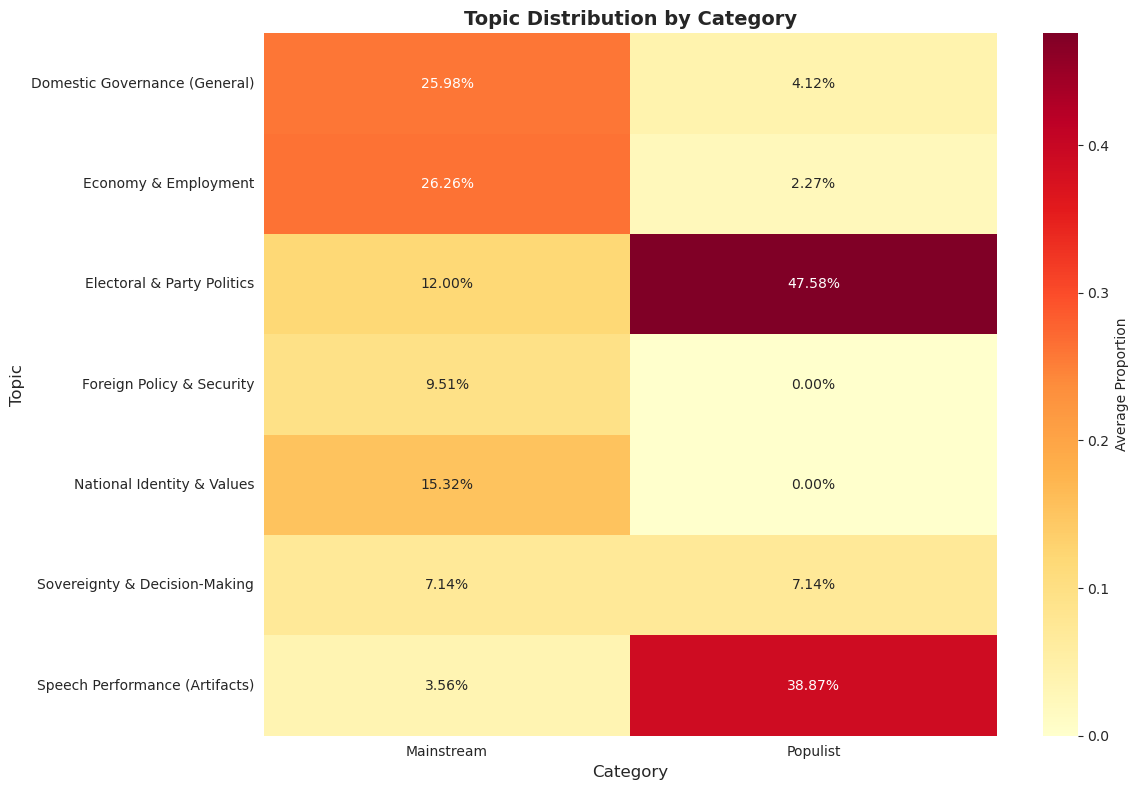

In [60]:
# ============================================================================
# SECTION 9: VISUALIZATIONS
# ============================================================================

# Visualization 1: Heatmap of topic distributions by category
pivot_df = comparison_df.pivot(index='Topic', columns='Category', values='Average_Proportion')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, annot=True, fmt='.2%', cmap='YlOrRd', cbar_kws={'label': 'Average Proportion'})
plt.title('Topic Distribution by Category', fontsize=14, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Topic', fontsize=12)
plt.tight_layout()
plt.show()

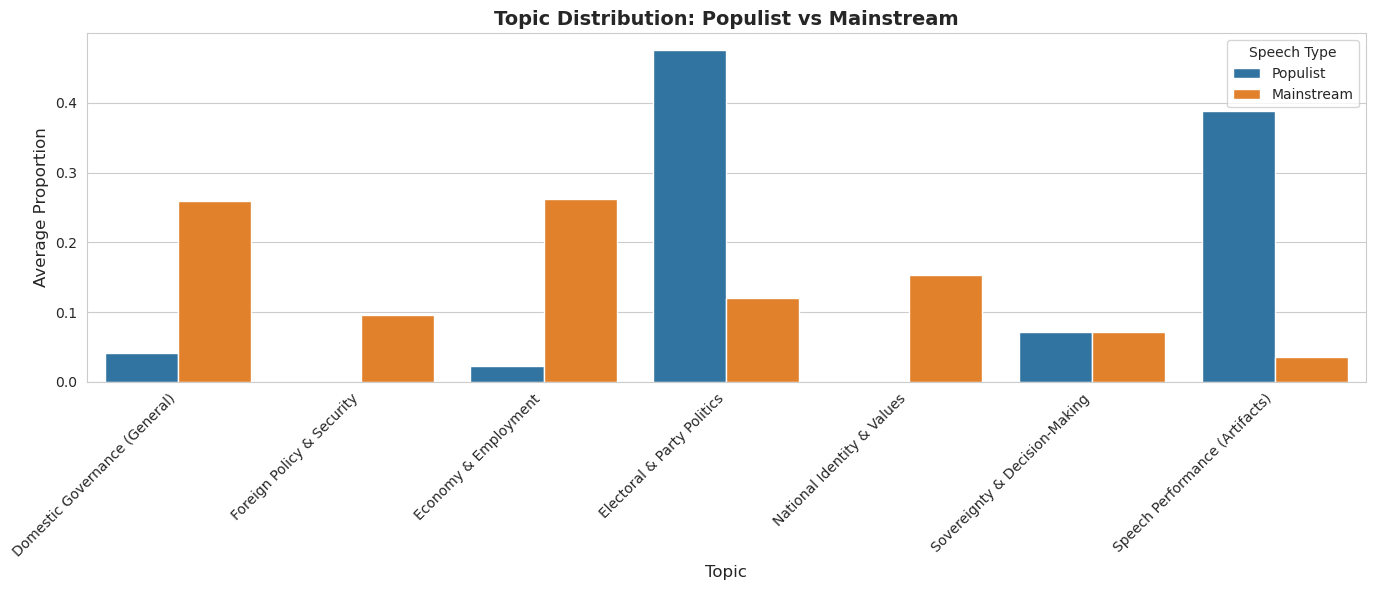

In [61]:
# Visualization 2: Bar chart comparing populist vs mainstream
# Group by populist/mainstream
metadata_df['type'] = metadata_df['category'].apply(
    lambda x: 'Populist' if 'populist' in x.lower() else 'Mainstream'
)

type_comparison = []
for speech_type in ['Populist', 'Mainstream']:
    type_df = metadata_df[metadata_df['type'] == speech_type]
    for topic_num in range(optimal_model.num_topics):
        avg = type_df[f'topic_{topic_num}'].mean()
        type_comparison.append({
            'Type': speech_type,
            'Topic': topic_names.get(topic_num, f"Topic {topic_num}"),
            'Average_Proportion': avg
        })

type_comparison_df = pd.DataFrame(type_comparison)

plt.figure(figsize=(14, 6))
sns.barplot(data=type_comparison_df, x='Topic', y='Average_Proportion', hue='Type')
plt.title('Topic Distribution: Populist vs Mainstream', fontsize=14, fontweight='bold')
plt.xlabel('Topic', fontsize=12)
plt.ylabel('Average Proportion', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Speech Type')
plt.tight_layout()
plt.show()

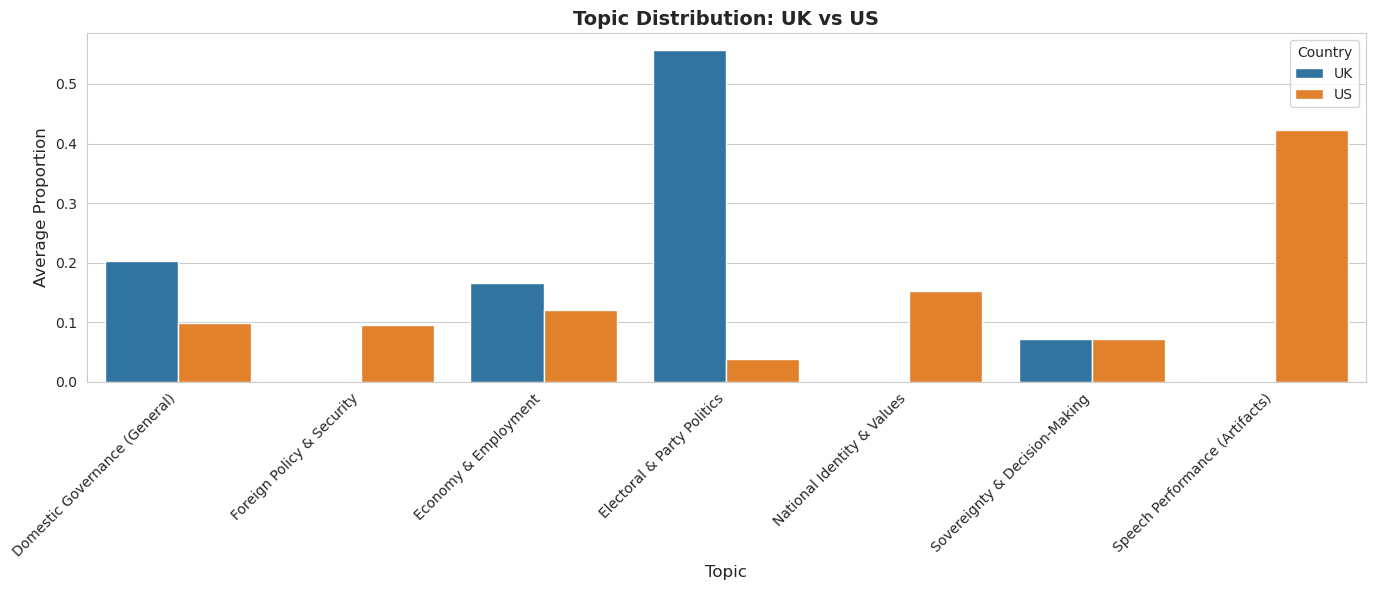

In [62]:
# Visualization 3: Compare UK vs USA
country_comparison = []
for country in ['UK', 'US']:
    country_df = metadata_df[metadata_df['country'] == country]
    for topic_num in range(optimal_model.num_topics):
        avg = country_df[f'topic_{topic_num}'].mean()
        country_comparison.append({
            'Country': country,
            'Topic': topic_names.get(topic_num, f"Topic {topic_num}"),
            'Average_Proportion': avg
        })

country_comparison_df = pd.DataFrame(country_comparison)

plt.figure(figsize=(14, 6))
sns.barplot(data=country_comparison_df, x='Topic', y='Average_Proportion', hue='Country')
plt.title('Topic Distribution: UK vs US', fontsize=14, fontweight='bold')
plt.xlabel('Topic', fontsize=12)
plt.ylabel('Average Proportion', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Country')
plt.tight_layout()
plt.show()

In [63]:
# ============================================================================
# SECTION 10: IDENTIFY KEY FINDINGS
# ============================================================================

print("="*60)
print("KEY FINDINGS")
print("="*60)

# Find topics with biggest differences between populist and mainstream
print("\nTopics with largest differences (Populist vs Mainstream):\n")

for topic_num in range(optimal_model.num_topics):
    pop_avg = metadata_df[metadata_df['type'] == 'Populist'][f'topic_{topic_num}'].mean()
    main_avg = metadata_df[metadata_df['type'] == 'Mainstream'][f'topic_{topic_num}'].mean()
    diff = pop_avg - main_avg
    
    topic_name = topic_names.get(topic_num, f"Topic {topic_num}")
    
    if abs(diff) > 0.05:  # Only show meaningful differences
        direction = "MORE" if diff > 0 else "LESS"
        print(f"{topic_name}:")
        print(f"  Populist: {pop_avg:.2%} | Mainstream: {main_avg:.2%}")
        print(f"  → Populist speeches {direction} by {abs(diff):.2%}\n")

KEY FINDINGS

Topics with largest differences (Populist vs Mainstream):

Domestic Governance (General):
  Populist: 4.12% | Mainstream: 25.98%
  → Populist speeches LESS by 21.86%

Foreign Policy & Security:
  Populist: 0.00% | Mainstream: 9.51%
  → Populist speeches LESS by 9.51%

Economy & Employment:
  Populist: 2.27% | Mainstream: 26.26%
  → Populist speeches LESS by 23.99%

Electoral & Party Politics:
  Populist: 47.58% | Mainstream: 12.00%
  → Populist speeches MORE by 35.57%

National Identity & Values:
  Populist: 0.00% | Mainstream: 15.32%
  → Populist speeches LESS by 15.32%

Speech Performance (Artifacts):
  Populist: 38.87% | Mainstream: 3.56%
  → Populist speeches MORE by 35.31%



In [64]:
# ============================================================================
# SECTION 11: SAVE RESULTS
# ============================================================================

# Save the dataframe with topic distributions
output_path = '/home/albere/compling/data/results/topic_modeling_results.csv'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
metadata_df.to_csv(output_path, index=False)
print(f"Results saved to: {output_path}")

# Save model for future use
model_path = '/home/albere/compling/data/models/lda_model'
optimal_model.save(model_path)
print(f"Model saved to: {model_path}")

# Save topic names
import json
topic_names_path = '/home/albere/compling/data/results/topic_names.json'
with open(topic_names_path, 'w') as f:
    json.dump(topic_names, f, indent=2)
print(f"Topic names saved to: {topic_names_path}")

print("\nAll results saved successfully!")

Results saved to: /home/albere/compling/data/results/topic_modeling_results.csv
Model saved to: /home/albere/compling/data/models/lda_model
Topic names saved to: /home/albere/compling/data/results/topic_names.json

All results saved successfully!


In [65]:
# ============================================================================
# SECTION 12: SUMMARY
# ============================================================================

print("="*60)
print("ANALYSIS COMPLETE!")
print("="*60)
print(f"\nCorpus: {len(metadata_df)} speeches")
print(f"Optimal model: {optimal_num_topics} topics")
print(f"Coherence score: {coherence_values[optimal_model_idx]:.4f}")
print(f"\nResults saved to: {output_path}")
print(f"Model saved to: {model_path}")
print("\nNext steps:")
print("  1. Review topic names and refine if needed")
print("  2. Analyze specific speeches with interesting topic distributions")
print("  3. Compare findings with other linguistic features")
print("  4. Document findings for assignment")

ANALYSIS COMPLETE!

Corpus: 28 speeches
Optimal model: 7 topics
Coherence score: 0.3426

Results saved to: /home/albere/compling/data/results/topic_modeling_results.csv
Model saved to: /home/albere/compling/data/models/lda_model

Next steps:
  1. Review topic names and refine if needed
  2. Analyze specific speeches with interesting topic distributions
  3. Compare findings with other linguistic features
  4. Document findings for assignment
